In [1]:
from sklearn import datasets, linear_model

from sklearn.model_selection import cross_val_predict, cross_val_score, validation_curve, train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_error

from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from catboost import CatBoostRegressor

from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import shap
import featuretools as ft
from pdpbox import pdp, info_plots

import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import os
import shutil

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [ ]:
def plot_train_test(exp_value, predicted_value, R2_value, name):
    plt.scatter(exp_value, predicted_value)
    
    _min = exp_value.min() #- 500
    _max = exp_value.max() #+ 500

    plt.plot([_min, _max], [_min, _max], color="red", linestyle='--')

    text_x = np.min(exp_value) + (np.max(exp_value) - np.min(exp_value)) * 0.01
    text_y = np.max(predicted_value) - (np.max(predicted_value) - np.min(predicted_value)) * 0.01
    plt.text(text_x, text_y, f'$R^2$ = {R2_value:.2f}', fontsize=18, color='red')
    
    plt.xlabel("Actual value", fontsize=18)
    plt.ylabel("Predicted value", fontsize=18)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.minorticks_on()

    ax = plt.gca()  
    ax.xaxis.set_minor_locator(MultipleLocator(100))  
    ax.yaxis.set_minor_locator(MultipleLocator(100)) 

    plt.tick_params(axis='both', which='minor', length=2, color='gray', direction='out', labelsize=10)

    plt.xlim(_min, _max)
    plt.ylim(_min, _max)

    plt.tight_layout()
    plt.show()
    plt.savefig(name + ".png")
    plt.clf()

In [3]:

used_features = ['mol_volume', 'mol_polar_area', 'logP', 'num_h_donors', 'num_h_acceptors', 'estate_indices_std', 'estate_indices_mean', 'chi1v', 'bond_lengths_mean']

filename = "features_training.xlsx"

data_targets = pd.read_excel(filename,index_col=0)
data_features = data_targets.loc[:,"mol_weight":][used_features]

tar_homo = data_targets["HOMO_eV"]

target = "HOMO_eV"
X = data_features.values
y = tar_homo



In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X,y,test_size=0.2,random_state=5)  # 5



# ML model

In [ ]:
def rfr():

    rfr_para = {'n_estimators':350,    # 200 
                'random_state':2,      # 2
                'min_samples_leaf':3,  # 2 
                'min_samples_split':4, # 3
                'max_features':10,      # 5
                # 'min_weight_fraction_leaf':0.01,
                # 'max_depth':10,
                'n_jobs':-1
                }
    rfr = RandomForestRegressor(**rfr_para)
    
    return rfr

def gbr():
    gbr_para = {'n_estimators': 70, #300, 
            'max_features': 5, #4,
            'max_depth': 6,
            'min_samples_split': 2, #5,
            'min_samples_leaf': 1, # 3,
            'learning_rate': 0.1,
            'random_state': 2}

    gbr = GradientBoostingRegressor(**gbr_para)

    return gbr

def svr():

    svr_para = {'C':3,
        'kernel':"rbf",
        'gamma' : 0.2,
        'epsilon':0.01
        }

    pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    # ('scaler',MinMaxScaler()),      
    ('svr',SVR(**svr_para))])

    return pipeline

def brg():
    brg = BaggingRegressor(estimator=None,
                        n_estimators=110,
                        max_samples=12,
                        max_features=9,
                        bootstrap=True,
                        bootstrap_features=False,
                        oob_score=False,
                        warm_start=False,
                        random_state=42,
                        verbose=0)
    return brg

def lgbm():
    lgbm = LGBMRegressor(n_estimators=160,
                        boosting_type='gbdt',
                        objective='regression',
                        # device= "gpu",
                        min_samples_split=2,
                        learning_rate=0.04,
                        random_state=0,
                        force_col_wise=True,
                        is_unbalance=True,
                        verbose=-1,
                        n_jobs=-1)
    return lgbm

def xgb():
    xgb = XGBRegressor(n_estimators=100,
                    reg_alpha = 0.1,
                    reg_lambda = 0.03,

                    # boosting_type='gbdt',
                    # objective='regression',
                    min_samples_split=2,
                    learning_rate=0.03,
                    random_state=0,
                    n_jobs=-1)
    return xgb

def kng():

    pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    # ('scaler',MinMaxScaler()),       

    ('kng',KNeighborsRegressor(n_neighbors=12, 
                        weights="distance" , # "uniform", # 
                        algorithm= "auto", #"auto", 
                        leaf_size = 2,
                        p=1, 
                        metric="minkowski", 
                        metric_params=None)) 
    ])

    return pipeline

def nn():
    pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    # ('scaler',MinMaxScaler()),       
    ('nn', MLPRegressor(random_state=2,
                  alpha=0.001,
                  activation='tanh',#'identity', #'relu',
                  solver='lbfgs', #'adam',
                  hidden_layer_sizes=(80,50),
                  max_iter=180))
    ])  
    
    return pipeline 

def cbr():
    cbr = CatBoostRegressor(iterations=300, #500
                            learning_rate=0.1,            # 0.03 
                            depth=8,                       #  8
                            loss_function='RMSE',          # 
                            l2_leaf_reg=3.0,               #  1
                            random_strength=1.2,           #  1.5 
                            early_stopping_rounds=50,      # 50
                            # use_best_model=True,           # 
                            # # task_type='GPU',     
                            random_state=2,         
                            verbose=False                 
                        )
    return cbr

def running_10fold(ML_model, X_train, Y_train):
    
    kf = KFold(n_splits=10, shuffle=True, random_state=2)

    ml_fit = ML_model.fit(X_train, Y_train)
    print(ml_fit)
    
    joblib.dump(ml_fit,"ml_model.pkl")

    cv_scores = cross_val_score(ml_fit, X_train, Y_train, cv=kf, scoring='r2') 
    cv_rmse_scores = -cross_val_score(ml_fit, X_train, Y_train, cv=kf, scoring='neg_root_mean_squared_error')
    R2_value = np.mean(cv_scores)
    print(f"Cross-validation R2 scores: {cv_scores}")
    print(f"Mean CV R2: {np.mean(cv_scores):.3f}")
    print(f"Cross-validation RMSE scores: {cv_rmse_scores}")
    print(f"Mean CV RMSE: {np.mean(cv_rmse_scores):.3f}")

    mae = -cross_val_score(ml_fit, X_train, Y_train, cv=kf, scoring='neg_mean_absolute_error') 
    print(f"Cross-validation MAE scores: {mae}")
    print(f"Mean CV MAE: {np.mean(mae):.3f}")

    mse = -cross_val_score(ml_fit, X_train, Y_train, cv=kf, scoring='neg_mean_squared_error') 
    print(f"Cross-validation MSE scores: {mse}")
    print(f"Mean CV MSE: {np.mean(mse):.3f}")

    
    all_actuals = []
    all_predictions = []

    for fold, (train_index, test_index) in enumerate(kf.split(X_train), start=1):

        # print(f"Fold {fold}")
        
        X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
        y_train_fold, y_test_fold = Y_train.iloc[train_index], Y_train.iloc[test_index]
        
       
        ML_model.fit(X_train_fold, y_train_fold)
        y_pred_fold = ML_model.predict(X_test_fold)
        
        
        all_actuals.extend(y_test_fold)
        all_predictions.extend(y_pred_fold)
        
        
        # print(f"Actual values: {y_test_fold.values}")
        # print(f"Predicted values: {y_pred_fold}")
        # print(f"Fold {fold} R2: {r2_score(y_test_fold, y_pred_fold):.3f}//n")
    
  
    all_actuals = np.array(all_actuals)
    all_predictions = np.array(all_predictions)
    
    plot_train_test(all_actuals, all_predictions, R2_value, "train")

    df_train = pd.concat([pd.DataFrame(all_actuals,columns=["Actual value"]), pd.DataFrame(all_predictions, columns=["Predicted value"])], axis=1)
    df_train.to_excel("training_actual_predicted.xlsx")

    return df_train

def run_test(X_test, Y_test): #ML_model, X_train, Y_train,

    test_actual = Y_test.reset_index(drop=True)
    test_actual.columns = ["Actual value"]

    # ml_fit = ML_model.fit(X_train, Y_train)
    ml_fit = joblib.load("ml_model.pkl")

    test_predicted_np = ml_fit.predict(X_test)

    test_predicted = pd.DataFrame(test_predicted_np, columns = ["Predicted value"])

    score_test = r2_score(test_predicted, Y_test)

    print(f'score of test_set: {score_test}')

    plot_train_test(Y_test, test_predicted, score_test, "test")

    df_test = pd.concat([test_actual,test_predicted], axis = 1)
    df_test.to_excel("test_actual_predicted.xlsx")

    return df_test


def verification(X_verification, Y_verification): #ML_model, X_train, Y_train, 

    # ml_fit = ML_model.fit(X_train, Y_train)
    ml_fit = joblib.load("ml_model.pkl") 

    test_verification_np = ml_fit.predict(X_verification)

    score_verification = r2_score(test_verification_np, Y_verification)

    X_verification["Predicted"] = list(test_verification_np)
    X_verification.to_excel("predicted_value_verificaton.xlsx")

    print(score_verification)

    plot_train_test(Y_verification, test_verification_np, score_verification, "verification")

def features_importance(used_features):

    # clf = ML_model.fit(X_train, Y_train)
    # importances = clf.feature_importances_
    # print(importances)

    clf = joblib.load("ml_model.pkl")

    result = permutation_importance(clf, X_test, Y_test, n_repeats=10, random_state=0)
    importance = result.importances_mean

    features_list = []
    for feature_name, score_ in zip(used_features,importance):
        # print(f"Feature: {feature_name}, Importance: {score_}")
        features_list.append([feature_name, score_])

    score_pd = pd.DataFrame(features_list, columns=["Name", "Score"]).sort_values(by='Score', ascending=False)

    score_pd.to_excel("importance.xlsx")
    
    return score_pd


Cross-validation R2 scores: [0.80039803 0.84323583 0.81184872 0.86455967 0.89756197 0.85437701
 0.78307464 0.92484248 0.77262087 0.86254724]
Mean CV R2: 0.842
Cross-validation RMSE scores: [0.29329555 0.26986296 0.30835876 0.25128931 0.23798837 0.25049159
 0.29457084 0.19021645 0.26980937 0.240621  ]
Mean CV RMSE: 0.261
Cross-validation MAE scores: [0.21046905 0.19100268 0.23516048 0.17268847 0.16636582 0.17031457
 0.20553653 0.15161615 0.17546406 0.19280296]
Mean CV MAE: 0.187
Cross-validation MSE scores: [0.08602228 0.07282602 0.09508513 0.06314632 0.05663847 0.06274604
 0.08677198 0.0361823  0.07279709 0.05789846]
Mean CV MSE: 0.069


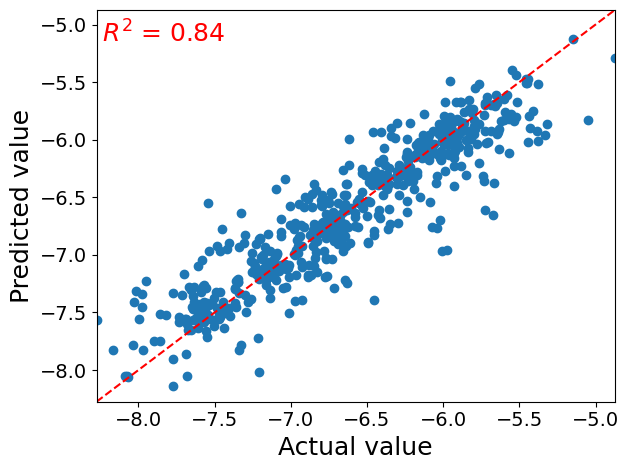

score of test_set: 0.8584353637518976


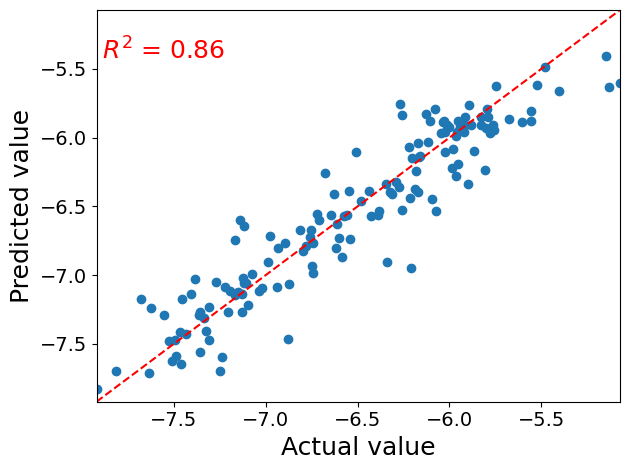

<Figure size 640x480 with 0 Axes>

In [6]:
ML_model = cbr()  # kng # nn # xgb # lgbm # brg # svr # rfr # gbr

df_train = running_10fold(ML_model, X_train, Y_train)

df_test = run_test(X_test, Y_test) #ML_model, X_train, Y_train, 

importance_pd = features_importance(used_features)

LGBMRegressor(force_col_wise=True, is_unbalance=True, learning_rate=0.04,
              min_samples_split=2, n_estimators=160, n_jobs=-1,
              objective='regression', random_state=0, verbose=-1)
Cross-validation R2 scores: [0.79462927 0.79414943 0.80774827 0.87446366 0.86830042 0.83267789
 0.81191949 0.88878564 0.80773727 0.84707544]
Mean CV R2: 0.833
Cross-validation RMSE scores: [0.29750367 0.30924018 0.31170074 0.24192722 0.26984683 0.26850653
 0.2742878  0.23138877 0.24810144 0.25380222]
Mean CV RMSE: 0.271
Cross-validation MAE scores: [0.22631178 0.22242438 0.24718681 0.17603479 0.1953129  0.19222356
 0.20770324 0.16779759 0.17007315 0.20000645]
Mean CV MAE: 0.201
Cross-validation MSE scores: [0.08850843 0.09562949 0.09715735 0.05852878 0.07281731 0.07209576
 0.0752338  0.05354076 0.06155432 0.06441556]
Mean CV MSE: 0.074


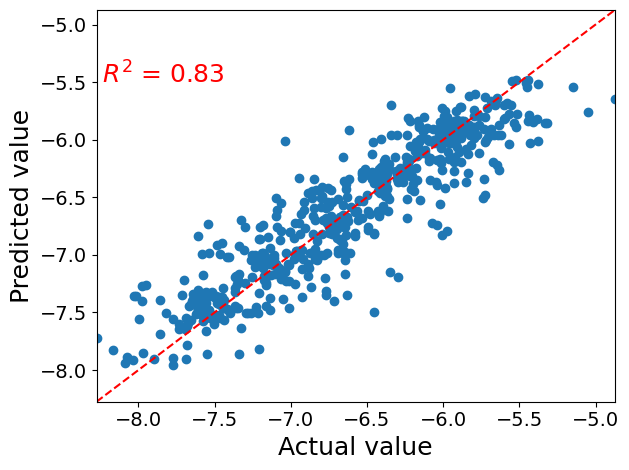

score of test_set: 0.8347196577146774


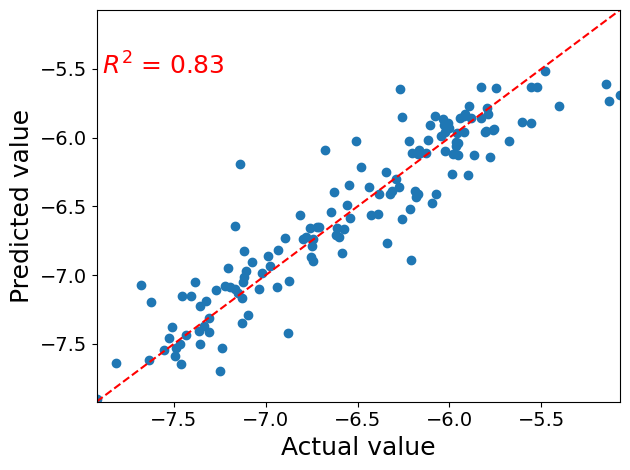

<Figure size 640x480 with 0 Axes>

In [7]:
ML_model = lgbm()  # kng # nn # xgb # lgbm # brg # svr # rfr # gbr

df_train = running_10fold(ML_model, X_train, Y_train)

df_test = run_test(X_test, Y_test) #ML_model, X_train, Y_train, 

importance_pd = features_importance(used_features)
